In [1]:
'''
Neural Network w/ graph-convolution layers w/ small N-body data
'''

'''
IMPORT N-BODY SIMULATIONS
'''
import glob
import struct
import numpy as np

# read simulation output into arrays of shape (b,N_p,6), b=batch size, N_p=set size=number of particles
def read_sim(file_list,N_part):
    batch = []
    for file_name in file_list:
        this_set = []
        with open(file_name, "rb") as f:
            for i in range(N_part*6):
                s = struct.unpack('=f',f.read(4))
                this_set.append(s[0])
        batch.append(this_set)
    batch = np.array(batch).reshape([len(file_list),N_part,6])  
    return batch

# z=0.4 and z=0.0
# replace path to simulations output
z20_files = glob.glob('./sim_1/DM*/xv_dm.z=02.0000')
z00_files = glob.glob('./sim_1/DM*/xv_dm.z=00.0000')

# number of particles
N_p = 16**3
batch_20 = read_sim(z20_files,N_p)
batch_00 = read_sim(z00_files,N_p)

# normalize coordinates and velocities by their mean/std
def normalize(X_in):
    X_1 = np.reshape(X_in,[-1,6])
    coo_mean, coo_std = np.mean(X_1[:,:3],axis=0), np.std(X_1[:,:3],axis=0)
    v_mean, v_std = np.mean(X_1[:,3:],axis=0), np.std(X_1[:,3:],axis=0)
    X_1[:,:3] = (X_1[:,:3]-coo_mean)/coo_std
    X_1[:,3:] = (X_1[:,3:]-v_mean)/v_std
    return np.reshape(X_1,[X_in.shape[0],X_in.shape[1],6])

# for simplicity I'm using mean/std normalization both for input and truth, just to get everything on the same scale
# normalization for the truth should be replaced with some constant factor normalization
batch_20 = normalize(batch_20)
batch_00 = normalize(batch_00)

In [3]:
'''
PRE-PROCESSING: nearest-neighbors and sparse adjacency
'''

import tensorflow as tf
import matplotlib.pyplot as plt
from random import randrange
from numpy import linalg as LA
%matplotlib inline

'''
SPARSE ADJACENCY MATRIX 
• scikit learn gives a CRS sparse adjacency for example, sparse TF takes COO. Use this for sparse X dense matmul in TF.
• also return adjacency lists and convert alist into index list to be used for generic normalizations (avg, max, etc)
'''

from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors


# # returns indices of non-zero elements, to be used in tf.SparseTensor
# def adjacency_COO(X_in,k):
#     shape_in = X_in.shape
#     X_out = np.zeros([shape_in[0],shape_in[1]*k,shape_in[2]])
#     for b in range(shape_in[0]):
#         X_out[b] = np.column_stack(kneighbors_graph(X_in[b],k,include_self=True).nonzero())
#     return X_out

# returns adjacency lists based on NN in coordinate space
def adjacency_list(X_in,k):
    shape_in = X_in.shape
    X_out = np.zeros([shape_in[0],shape_in[1],k],dtype=np.int32)
    for b in range(shape_in[0]):
        X_out[b] = kneighbors_graph(X_in[b,:,:3],k,include_self=True).indices.reshape([shape_in[1],k])
    return X_out

# tf.gather works for one batch and takes the adjacency list. Need to use gather_nd for the batched version.
# adjacency list to proper index list for gather_nd
def alist_to_indexlist(alist):
    b = alist.shape[0] # batch size
    n = alist.shape[1] # set size
    k = alist.shape[2] # number of nn
    id1 = np.reshape(np.arange(b),[b,1])
    id1 = np.tile(id1,n*k).flatten()
    out = np.stack([id1,alist.flatten()],axis=1)
    return out

n_NN = 30
# # example
# alist_04 = adjacency_list(batch_20[:10],n_NN)
# ilist_04 = alist_to_indexlist(alist_04)
# ilist_04.shape

In [4]:
'''
Subset layers
'''

'''
batch multiplications
'''
# T1=(b,n,k)|T2=(k,r)
# Tout=(b,n,r)
def left_mult(T1,T2):
    Tout = tf.einsum('ijl,lq->ijq',T1,T2)
    return Tout

'''
SUBSET LAYER w/ ADJACENCY (graph-convolution)
max/avg normalization, index_list = nn
'''
def graph_subset_layer_beta(X_in,index_list,L,G,space_dim,NN_dim,activation=tf.identity,dropout=False,keep_prob=1.):
    dim = tf.shape(X_in)
    b = dim[0]; n = dim[1]
    X_1 = tf.reshape(tf.gather_nd(X_in,index_list),[b,n,NN_dim,space_dim])
    X_2 = tf.reduce_mean(X_1,axis=2)
    #X_2 = tf.reduce_max(X_1,axis=2)
    X_3 = left_mult(X_in,L) + left_mult(X_2,G)
    X_4 = activation(X_3)
    X_out = X_4
    # dropout (simultaneous along set dimension)
    if dropout:
        k_out = tf.shape(L)[1]
        X_out = tf.nn.dropout(X_4,keep_prob,noise_shape=[b,1,k_out])
    return  X_out

'''
Mini-batch
'''
def next_minibatch(in_list,batch_size):
    if all(len(i) == len(in_list[0]) for i in in_list) == False:   
        raise ValueError('Inputs do not have the same dimension')
    index_list = np.random.randint(len(in_list[0]), size=batch_size)
    out = list()
    for k in range(len(in_list)):
        out.append(np.array([in_list[k][i] for i in index_list]))
    return out

In [22]:
'''
Neural Network
'''
# initialize params
def w_variable(shape,name=None):
    initial = tf.truncated_normal(shape, stddev=1e-3)
    if name is None:
        out = tf.Variable(initial)
    else:
        out = tf.Variable(initial,name=name)
    return out

# def b_variable(shape):
#     initial = tf.constant(1e-2, shape=shape)
#     return tf.Variable(initial)

# in/out channels
k_in = 6
k_out = 6

# dropout probability
keep_prob = tf.placeholder(tf.float32)

# input 
X_input = tf.placeholder(tf.float32, shape=[None,N_p,k_in], name='X_input')
# truth
X_truth = tf.placeholder(tf.float32, shape=[None,N_p,k_out], name='X_truth')
# info about nn, in the form of a indexlist, has shape (batch_size*set_size*nn,2)
index_list = tf.placeholder(tf.int32, shape=[None,2], name='index_list') 


'''
Layer 1
'''
k1 = 64 # output channels
L1 = w_variable([k_in,k1],name='L1')
G1 = w_variable([k_in,k1],name='G1')
out1 = graph_subset_layer_beta(X_input,index_list,L1,G1,k_in,n_NN,activation=tf.nn.relu,dropout=True)


'''
Layer 2
'''
k2 = 64 # output channels
L2 = w_variable([k1,k2],name='L2')
G2 = w_variable([k1,k2],name='G2')
out2 = graph_subset_layer_beta(out1,index_list,L2,G2,k1,n_NN,activation=tf.nn.relu,dropout=True)

'''
Layer 3
'''
k3 = 64 # output channels
L3 = w_variable([k2,k3],name='L3')
G3 = w_variable([k2,k3],name='G3')
out3 = graph_subset_layer_beta(out2,index_list,L3,G3,k2,n_NN,activation=tf.nn.relu,dropout=True)


'''
Output layer
'''
L_out = w_variable([k3,k_out],name='L_out')
G_out = w_variable([k3,k_out],name='G_out')
readout = graph_subset_layer_beta(out3,index_list,L_out,G_out,k3,n_NN,activation=tf.identity,dropout=False)


'''
Loss Function
'''
# L2-distance 
loss = tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(tf.square(readout-X_truth),axis=2),axis=1),axis=0,name='loss')


'''
Optimization
'''
train_step = tf.train.AdamOptimizer(1e-2).minimize(loss)

Stopped at loss =  0.491925


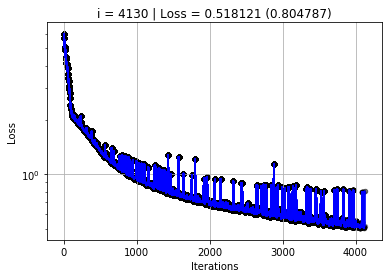

In [24]:
'''
Training
'''
saver = tf.train.Saver()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

import time
from IPython import display

# iterations
n_iter = 5000

# minibatch size
mb_size = 10

t = list()
loss_vals = list()

for i in range(n_iter):
    # get input and truth minibatch and get nn indexlist
    batch = next_minibatch([batch_20,batch_00],mb_size)
    alist = adjacency_list(batch[0],n_NN)
    ilist = alist_to_indexlist(alist)
    # plot loss evolution
    if i%5 == 0:
        t.append(i)
        this_loss = sess.run(loss,feed_dict={X_input: batch[0], X_truth: batch[1], index_list: ilist, keep_prob: 1.})
        loss_vals.append(this_loss)
        if this_loss < 0.5:
            print 'Stopped at loss = ', this_loss
            break
        plt.yscale('log')
        plt.grid(True)
        plt.plot(t,loss_vals,'b-')
        plt.scatter(t,loss_vals,color='black',s=20,alpha=.3)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.grid(True)
        if len(t) > 1:
            plt.title('i = '+str(t[-1])+' | Loss = '+str(loss_vals[-1])+' ('+str(loss_vals[-2])+')')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)    
        
    train_step.run(feed_dict={X_input: batch[0], X_truth: batch[1], index_list: ilist, keep_prob: .8})

In [1]:
#saver.save(sess, './models/3hl')

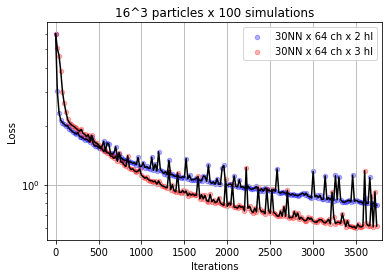

In [27]:
'''
save learning curves
'''
# Save loss vals
#loss_10 = np.array([t,loss_vals])
#np.save('./saved_data_smallNbody/loss_10',loss_10)

'''
------------------
batch_size|z_in|z_final|n_NN|depth|channels
------------------
'''
# # 100|2.0|0.0|30|2|64
# # 100|2.0|0.0|30|2|128 >> no substantial improv
# loss_1 = np.load('./saved_data_smallNbody/loss_1.npy')

# # 100|2.0|0.0|80|2|64
# loss_3 = np.load('./saved_data_smallNbody/loss_3.npy')

# # 100|2.0|0.0|30|3|64
# loss_4 = np.load('./saved_data_smallNbody/loss_4.npy')

# # 100|2.0|0.0|30|2|64
# loss_5 = np.load('./saved_data_smallNbody/loss_5.npy')

# 100|2.0|0.0|30|3|64
loss_6 = np.load('./saved_data_smallNbody/loss_6.npy')

# 100|2.0|0.0|30|2|64
loss_7 = np.load('./saved_data_smallNbody/loss_7.npy')

# 100|2.0|0.0|30|4|64
loss_8 = np.load('./saved_data_smallNbody/loss_8.npy')

# 100|2.0|0.0|30|3|64
loss_9 = np.load('./saved_data_smallNbody/loss_9.npy')
# 100|2.0|0.0|30|3|64
loss_10 = np.load('./saved_data_smallNbody/loss_10.npy')


ind = []
for i in range(752):
    if i%4==0:
        ind.append(i)
loss_6X = loss_6[:,ind]
loss_7X = loss_7[:,ind]


'''
------------------
loss plots
------------------
'''
plt.yscale('log')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.xlim([-100,3800])
d1_a = plt.scatter(loss_7X[0],loss_7X[1],color='blue',s=20,alpha=.3)
d1_b = plt.plot(loss_7X[0],loss_7X[1],color='black')
d2_a = plt.scatter(loss_6X[0],loss_6X[1],color='red',s=20,alpha=.3)
d2_b = plt.plot(loss_6X[0],loss_6X[1],color='black')
#d3_a = plt.scatter(loss_4[0],loss_4[1],color='green',s=20,alpha=.3)
#d3_b = plt.plot(loss_4[0],loss_4[1],color='black')
plt.title('16^3 particles x 100 simulations')
plt.legend((d1_a,d2_a),('30NN x 64 ch x 2 hl','30NN x 64 ch x 3 hl'),scatterpoints=1,loc='upper right',fontsize=10)
plt.show()


Loss =  0.497746


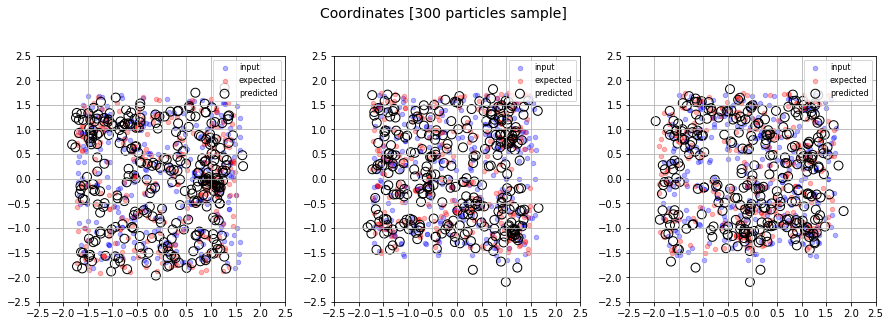

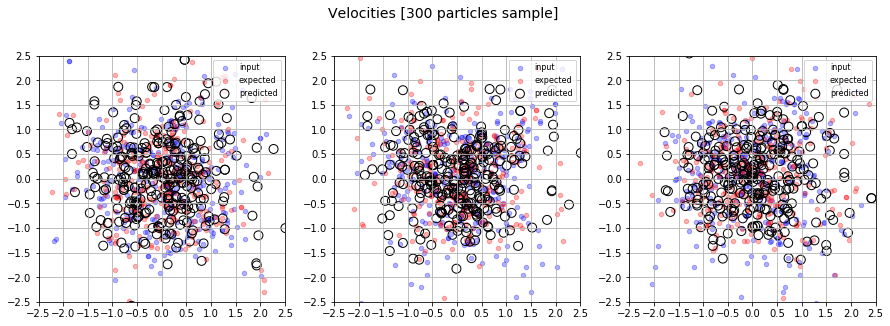

In [28]:
# 2D slices from the training set
test = next_minibatch([batch_20,batch_00],10)
alist_test = adjacency_list(test[0],n_NN)
ilist_test = alist_to_indexlist(alist_test)
out_test = sess.run(readout,feed_dict={X_input: test[0], index_list: ilist_test, keep_prob: 1.})
test_loss = sess.run(loss,feed_dict={X_input: test[0], X_truth: test[1], index_list: ilist_test, keep_prob: 1.})
print 'Loss = ',test_loss

# select random points
ind = np.random.randint(N_p, size=300)
test_in = test[0][:,ind,:]
test_truth = test[1][:,ind,:]
test_out = out_test[:,ind,:]


fig = plt.figure()
fig.set_size_inches(15,5)
fig.suptitle('Coordinates [300 particles sample]', fontsize=14)
xylims = [-2.5,2.5]
slices=np.array([[0,1],[0,2],[1,2]])
example = 0
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,aspect='equal')
    ax.set_ylim(xylims)
    ax.set_xlim(xylims)
    inp = ax.scatter(test_in[example,:,slices[i][0]],test_in[example,:,slices[i][1]],color='blue',s=20,alpha=.3)
    tru = ax.scatter(test_truth[example,:,slices[i][0]],test_truth[example,:,slices[i][1]],color='red',s=20,alpha=.3)
    out = ax.scatter(test_out[example,:,slices[i][0]],test_out[example,:,slices[i][1]],edgecolors='black',s=80,facecolors='none')
    plt.legend((inp,tru,out),('input','expected', 'predicted'),scatterpoints=1,loc='upper right',fontsize=8)
    plt.xticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.yticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.grid(True)
plt.show()

fig = plt.figure()
fig.set_size_inches(15,5)
fig.suptitle('Velocities [300 particles sample]', fontsize=14)
xylims = [-2.5,2.5]
slices=np.array([[3,4],[3,5],[4,5]])
example = 0
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,aspect='equal')
    ax.set_ylim(xylims)
    ax.set_xlim(xylims)
    inp = ax.scatter(test_in[example,:,slices[i][0]],test_in[example,:,slices[i][1]],color='blue',s=20,alpha=.3)
    tru = ax.scatter(test_truth[example,:,slices[i][0]],test_truth[example,:,slices[i][1]],color='red',s=20,alpha=.3)
    out = ax.scatter(test_out[example,:,slices[i][0]],test_out[example,:,slices[i][1]],edgecolors='black',s=80,facecolors='none')
    plt.legend((inp,tru,out),('input','expected', 'predicted'),scatterpoints=1,loc='upper right',fontsize=8)
    plt.xticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.yticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.grid(True)
plt.show()

In [60]:
'''
Save/load full prediction on training batch_20
'''
# batch_20_out = np.zeros([100,4096,6])

# for i in range(10):
#     batch_in = batch_20[i*10:(i+1)*10]
#     alist_in = adjacency_list(batch_in,n_NN)
#     ilist_in = alist_to_indexlist(alist_in)
#     out = sess.run(readout,feed_dict={X_input: batch_in, index_list: ilist_in, keep_prob: 1.})
#     batch_20_out[i*10:(i+1)*10] = out    

#np.save('./saved_data/batch_20_out',batch_20_out)
batch_20_out = np.load('./saved_data/batch_20_out.npy')

In [ ]:
'''
Notes:

• explore depth/learning rate
• augment input w/ rotations and shifts
• more particles + larger training set
• compare power spectra
• 3D visualization

• try subsets instead of just GC, need to fix normalization
• batches with different redshifts

• Code: make it more compact, define wrapper for the network for example, save/restore models using tf
'''

In [44]:
'''
3D visualization
'''
import pylab as plt
from mayavi import mlab


def volumize_ptc(datain,# n x 3
                 opacity=.5, labels=None,
                 frame=True, row=0, col=0,
                 show=True,
                 figure=None,
                 proj=(False,True,True),
                 shadow=(False,True,True),
                 mode='point',
                 scale_factor=.015,
                 filename=None,
):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = datain.copy()
    data -= np.min(data, keepdims=True)
    data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj,yproj,zproj = proj
    xshadow,yshadow,zshadow=shadow
    if labels is None:
        pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))

    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))


    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show:
            mlab.clf()
    if show:
        mlab.show()

In [48]:
test = batch_20[0,:50,:3]
print test.shape

l1 = np.array([0 for i in range(25)]+[1 for i in range(25)])
fig = mlab.figure(1, size=(400, 400), bgcolor=(1, 1, 1), fgcolor=(1, 0, 0))

volumize_ptc(test,mode='sphere')

(50, 3)
